In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

import numpy as np
import sympy as sp
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens, Biprism
from temgym_core.gaussian import make_gaussian_image, GaussianRay, evaluate_gaussian_input_image
from temgym_core.source import ParallelBeam
from temgym_core.ray import Ray
from temgym_core.utils import fibonacci_spiral, custom_jacobian_matrix
from temgym_core.run import run_to_end, run_iter
from temgym_core.plotting import plot_model, PlotParams, plot_ray_bundle, _stack_ray_positions
from typing import Sequence, Tuple

%matplotlib widget
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [ ]:
scale = 1
aperture_window_width = 0.1e-6 * scale  # 0.5 um aperture window width
num_aper_pixels = 128
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 50e-9 * scale # 50 nm aperture radius

num_beams = int(1e5)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12 * scale  # 2 pm wavelength
k = 2 * np.pi / wavelength
wo = 1e-9 * scale

#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [3]:
# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)
extent = [input_aperture_grid.coords_1d[0][0], input_aperture_grid.coords_1d[0][-1], input_aperture_grid.coords_1d[1][0], input_aperture_grid.coords_1d[1][-1]]

Text(0.5, 1.0, 'Aperture Plane Amplitude')

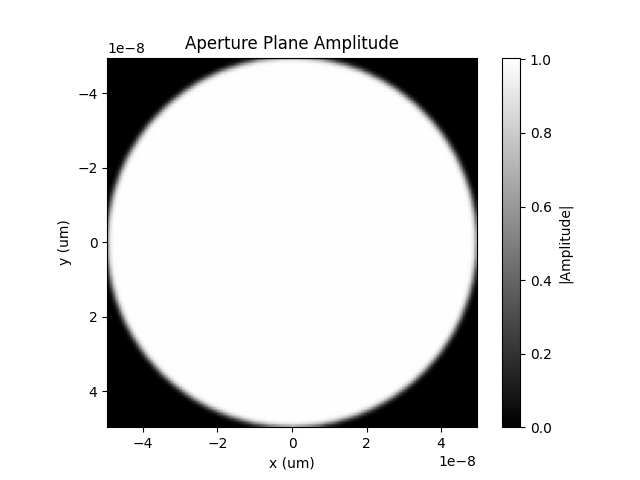

In [6]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray', extent=extent)
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar(label='|Amplitude|')
plt.title('Aperture Plane Amplitude')

In [7]:
M1 = -200
F1 = 0.0025 * scale
M2 = -1500
F2 = 0.02 * scale

defocus = 1e-9 * scale
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)
L2_z1 = F2 * (1/M2 - 1)
L2_z2 = F2 * (1 - M2)
L1_z1, L1_z2, L2_z1, L2_z2 = np.abs([L1_z1, L1_z2, L2_z1, L2_z2])

input_beam = ParallelBeam(z=0.0 + defocus, radius=aperture_radius)
lens1 = Lens(focal_length=F1, z=L1_z1)
biprism = Biprism(z=L1_z1 + L1_z2 / 2, rotation=0.0, def_x=-2e-5)
lens2 = Lens(focal_length=F2, z=L1_z1 + L1_z2 + L2_z1)
detector = Detector(z=L1_z1 + L1_z2 + L2_z1 + L2_z2, pixel_size=(55e-6 / 2, 55e-6 / 2), shape=(1024, 1024))
model = [
    input_beam,
    lens1,
    biprism,
    lens2,
    detector,
]

[[[[ 3.00000000e+05  0.00000000e+00 -3.00000000e-04  0.00000000e+00
    -7.53750000e-03]
   [ 0.00000000e+00  3.00000000e+05  0.00000000e+00 -3.00000000e-04
     0.00000000e+00]
   [ 1.00002667e+04  0.00000000e+00 -6.66693333e-06  0.00000000e+00
    -2.51263333e-04]
   [ 0.00000000e+00  1.00002667e+04  0.00000000e+00 -6.66693333e-06
     0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     1.00000000e+00]]]]


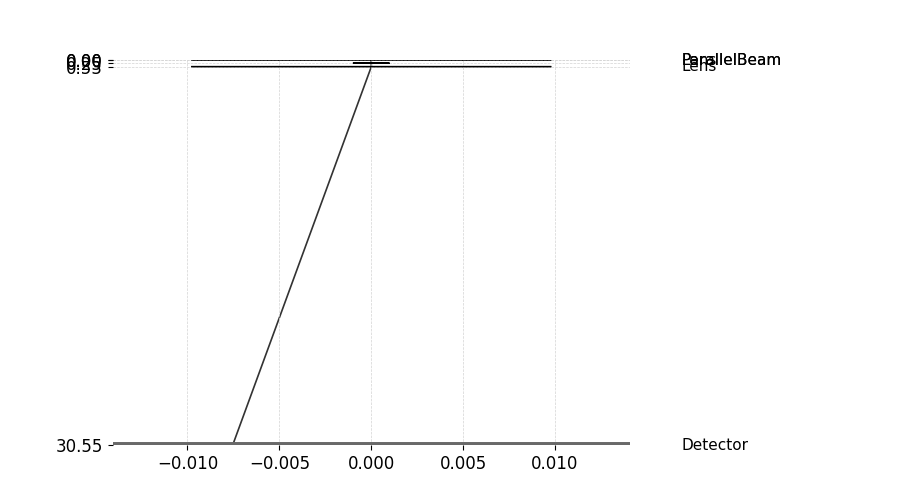

In [8]:
central_ray = Ray(x=1e-15, y=0.0, dx=0.0, dy=0.0, z=input_beam.z, pathlength=0.0, _one=1.0)
central_ray = central_ray.to_vector()
out_ray = run_to_end(central_ray, model)

ABCD = jax.jacobian(lambda r: run_to_end(r, model))(central_ray)
ABCD = custom_jacobian_matrix(ABCD)
ABCD[0, 0, :, :]

print(ABCD)

plot_params = PlotParams(ray_color='k', extent_scale = 1.2, lens_height=1e-6)
fig, ax = plot_model(model, rays = central_ray, plot_params=plot_params)

In [9]:
left_rays_indices = xs < 0.0
left_rays = GaussianRay(
    x=xs[left_rays_indices], 
    y=ys[left_rays_indices], 
    dx=jnp.ones_like(dxs[left_rays_indices]) * -0,
    dy=dys[left_rays_indices], 
    z=jnp.ones_like(xs[left_rays_indices]) * input_beam.z,
    pathlength=pathlengths[left_rays_indices], 
    _one=ones[left_rays_indices], 
    amplitude=amplitudes[left_rays_indices], 
    waist_xy=waist_xy[left_rays_indices],
    radii_of_curv=radii_of_curv[left_rays_indices],
    wavelength=wavelengths[left_rays_indices], 
    theta=theta[left_rays_indices],
)

right_rays_indices = xs > 0.0
right_rays = GaussianRay(
    x=xs[right_rays_indices],
    y=ys[right_rays_indices],
    dx=jnp.ones_like(dxs[right_rays_indices]) * 0,
    dy=dys[right_rays_indices],
    z=jnp.ones_like(xs[right_rays_indices]) * input_beam.z,
    pathlength=pathlengths[right_rays_indices],
    _one=ones[right_rays_indices],
    amplitude=amplitudes[right_rays_indices],
    waist_xy=waist_xy[right_rays_indices],
    radii_of_curv=radii_of_curv[right_rays_indices],
    wavelength=wavelengths[right_rays_indices],
    theta=theta[right_rays_indices],
)

det_image_left = make_gaussian_image(left_rays, model, batch_size=100)

det_image_right = np.fliplr(det_image_left)

In [10]:
det_image = det_image_left + det_image_right

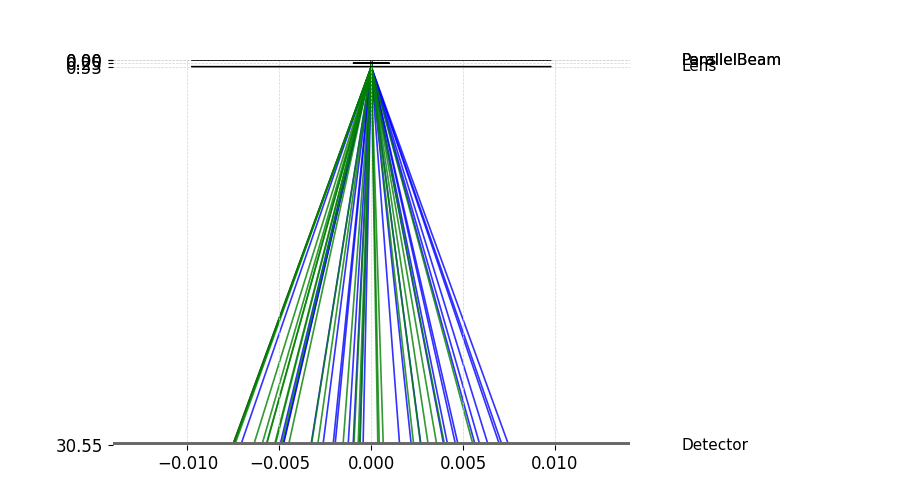

In [11]:
left_rays = left_rays.to_ray()
right_rays = right_rays.to_ray()
out_rays_left = run_to_end(left_rays, model)
out_rays_right = run_to_end(right_rays, model)

# Accumulate rays after each step (including propagations)
steps: list[Tuple[object, Ray]] = list(run_iter(left_rays, model))
X, Z = _stack_ray_positions(steps)
plot_params = PlotParams(ray_color='b')
plot_ray_bundle(ax, X[:, 0::1000], Z, plot_params, band_mode='lines')

steps: list[Tuple[object, Ray]] = list(run_iter(right_rays, model))
X, Z = _stack_ray_positions(steps)
plot_params = PlotParams(ray_color='g')
plot_ray_bundle(ax, X[:, 0::1000], Z, plot_params, band_mode='lines')

plt.show()

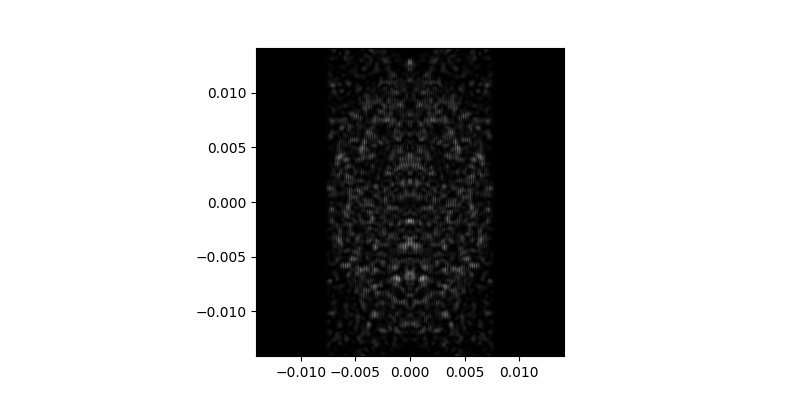

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
img = np.abs(det_image) ** 2
ang = np.angle(det_image)
ax.imshow(img, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])
#ax.imshow(ang, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2], alpha=0.5)


In [13]:
from skimage.restoration import unwrap_phase


def find_sideband_center(mag, exclude_radius=30):
    h, w = mag.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    dist2 = (Y - cy)**2 + (X - cx)**2
    search = mag.copy()
    search[dist2 <= exclude_radius**2] = 0.0
    iy, ix = np.unravel_index(np.argmax(search), mag.shape)
    return (iy, ix)

def gaussian_sideband_filter(fft_shifted, center, sigma):
    h, w = fft_shifted.shape
    Y, X = np.ogrid[:h, :w]
    mask = np.exp(-(((X - center[1])**2 + (Y - center[0])**2) / (2 * sigma**2)))
    filtered_fft = fft_shifted * mask
    recon = np.fft.ifft2(np.fft.ifftshift(filtered_fft))
    return recon, mask, filtered_fft

# View the fft of the intensity pattern
fft_img = np.fft.fftshift(np.fft.fft2(img))
fft_magnitude = np.abs(fft_img)
fft_phase = np.angle(fft_img)

# Auto-detect a sideband (exclude low-frequency DC core)
sideband_center = find_sideband_center(fft_magnitude, exclude_radius=20)
sigma_pixels = 30  # adjust as needed

recon_sideband, gaussian_mask, sideband_fft = gaussian_sideband_filter(fft_img, sideband_center, sigma_pixels)

# Reconstructed sideband (complex field)
recon_amp = np.abs(recon_sideband)
recon_phase = np.angle(recon_sideband)

unwrapped_phase = unwrap_phase(recon_phase)

row_idx = unwrapped_phase.shape[0] // 2
unwrapped_row = unwrapped_phase[row_idx, :]

unwrapped_row_cutoff_edges = unwrapped_row[300:-300]
# Optical path difference (m) from phase: φ = 2π * OPD / λ  =>  OPD = λ * φ / (2π)
opd = (wavelength / (2 * np.pi)) * unwrapped_row_cutoff_edges  # meters

# Wavefront slopes (small-angle approx): slope ≈ ∇(OPD)
dopd_dx = np.gradient(opd, detector.pixel_size[0]) / 2

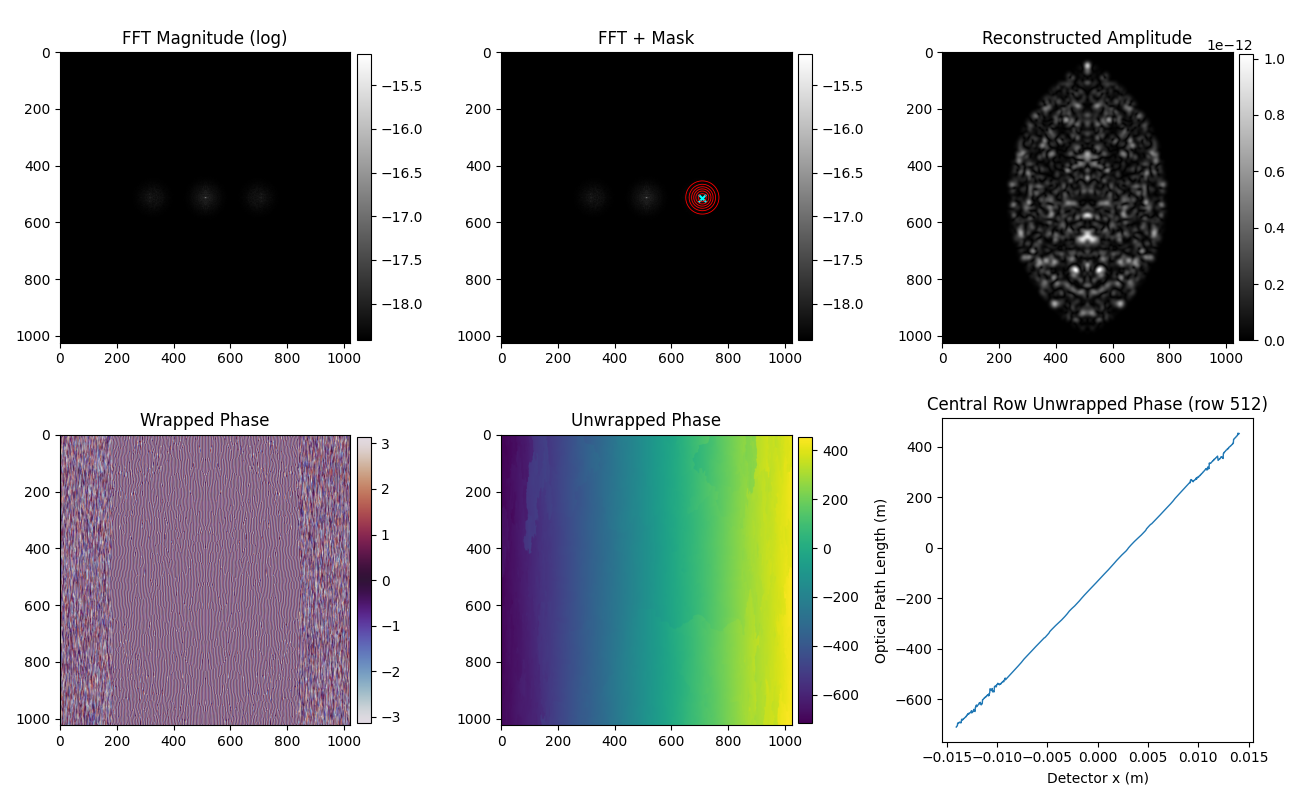

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))

# 1. FFT Magnitude (log scale)
im0 = axes[0, 0].imshow(np.log(fft_magnitude + 1e-8), cmap='gray')
axes[0, 0].set_title('FFT Magnitude (log)')
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.02)

# 2. FFT Magnitude with Gaussian sideband mask
im1 = axes[0, 1].imshow(np.log(fft_magnitude + 1e-8), cmap='gray')
axes[0, 1].contour(gaussian_mask, levels=6, colors='r', linewidths=0.6)
axes[0, 1].scatter([sideband_center[1]], [sideband_center[0]], c='cyan', s=30, marker='x')
axes[0, 1].set_title('FFT + Mask')
fig.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.02)

# 3. Reconstructed Sideband Amplitude
im2 = axes[0, 2].imshow(recon_amp, cmap='gray')
axes[0, 2].set_title('Reconstructed Amplitude')
fig.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.02)

# 4. Wrapped Phase
im3 = axes[1, 0].imshow(recon_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title('Wrapped Phase')
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.02)

# 5. Unwrapped Phase
im4 = axes[1, 1].imshow(unwrapped_phase, cmap='viridis')
axes[1, 1].set_title('Unwrapped Phase')
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.02)


axes[1, 2].plot(detector.coords_1d[0], unwrapped_row, lw=1)
axes[1, 2].set_title(f'Central Row Unwrapped Phase (row {row_idx})')
axes[1, 2].set_xlabel('Detector x (m)')
axes[1, 2].set_ylabel('Optical Path Length (m)')

plt.tight_layout()
plt.show()